# Commodity Inflation Factor Analysis Background

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\root\src")
from InflationFactorGenerator import FactorModel

## Original Raw Data

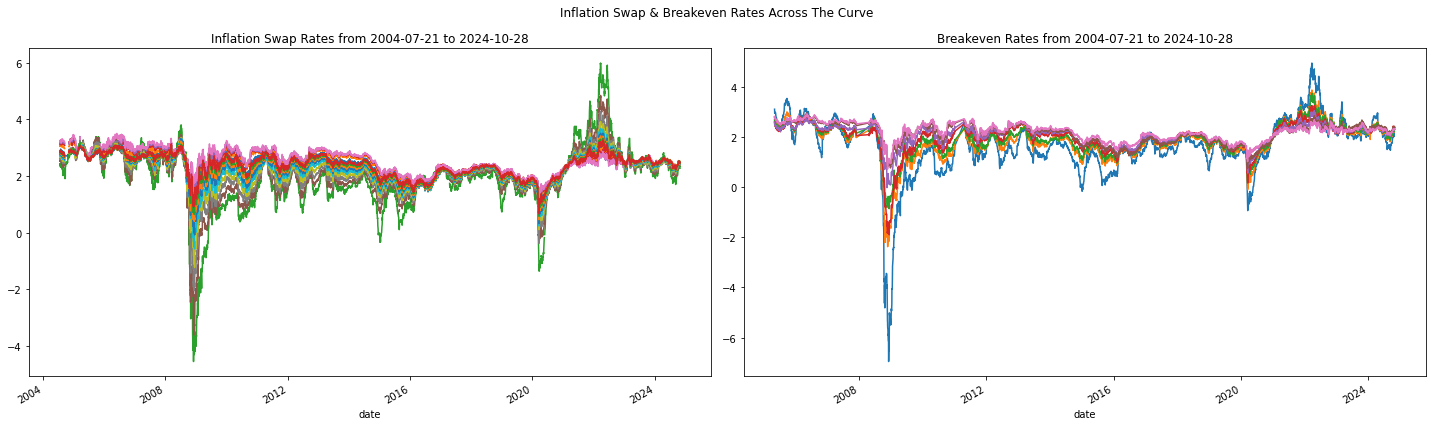

In [3]:
def plot_inflation_rates() -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_inflation = (FactorModel().get_inflation_swap().assign(
        security = lambda x: x.Description.str.split(" ").str[-1])
        [["date", "security", "value"]].
        pivot(index = "date", columns = "security", values = "value"))

    df_breakeven = (FactorModel().get_breakeven()[
        ["date", "security", "value"]].
        pivot(index = "date", columns = "security", values = "value").
        dropna())

    df_inflation.plot(
        ax     = axes[0],
        legend = False,
        title  = "Inflation Swap Rates from {} to {}".format(
            df_inflation.index.min().date(),
            df_inflation.index.max().date()))

    df_breakeven.plot(
        ax     = axes[1],
        legend = False,
        title  = "Breakeven Rates from {} to {}".format(
            df_inflation.index.min().date(),
            df_inflation.index.max().date()))

    fig.suptitle("Inflation Swap & Breakeven Rates Across The Curve")
    plt.tight_layout()
    
plot_inflation_rates()

## Principal Components

First start looking at the principal components of the breakeven curve and the inflation swap curve

In [4]:
def get_fitted_values() -> pd.DataFrame: 
    
    data_path = r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\data\FittedPCValues"
    df_out = (pd.concat([(pd.read_parquet(
        path = os.path.join(data_path, file), engine = "pyarrow").
        assign(inflation_group = file.split(".")[0])) 
         for file in os.listdir(data_path)]))
    
    return df_out

df_fitted = get_fitted_values()

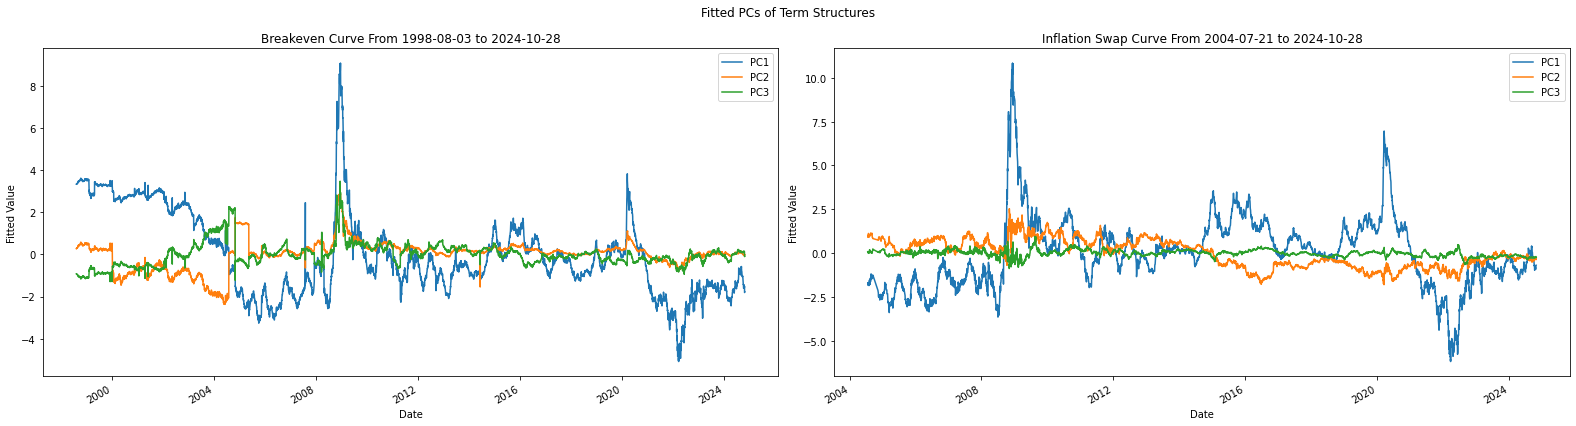

In [5]:
def plot_fitted_values(df_fitted: pd.DataFrame) -> plt.Figure: 
    
    inflation_groups = df_fitted.inflation_group.drop_duplicates().to_list()
    fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (22,6))

    renamer = {
        "BreakevenRate" : "Breakeven Curve",
        "InflationSwaps": "Inflation Swap Curve"}

    for inflation_group, ax in zip(inflation_groups, axes.flatten()):

        df_plot = (df_fitted.query(
            "inflation_group == @inflation_group").
            drop(columns = ["inflation_group"]))

        (df_plot.plot(
            ax     = ax,
            xlabel = "Date",
            ylabel = "Fitted Value",
            title  = "{} From {} to {}".format(
                renamer[inflation_group],
                df_plot.index.min().date(),
                df_plot.index.max().date())))
        
    fig.suptitle("Fitted PCs of Term Structures")
    plt.tight_layout()
    
plot_fitted_values(df_fitted)

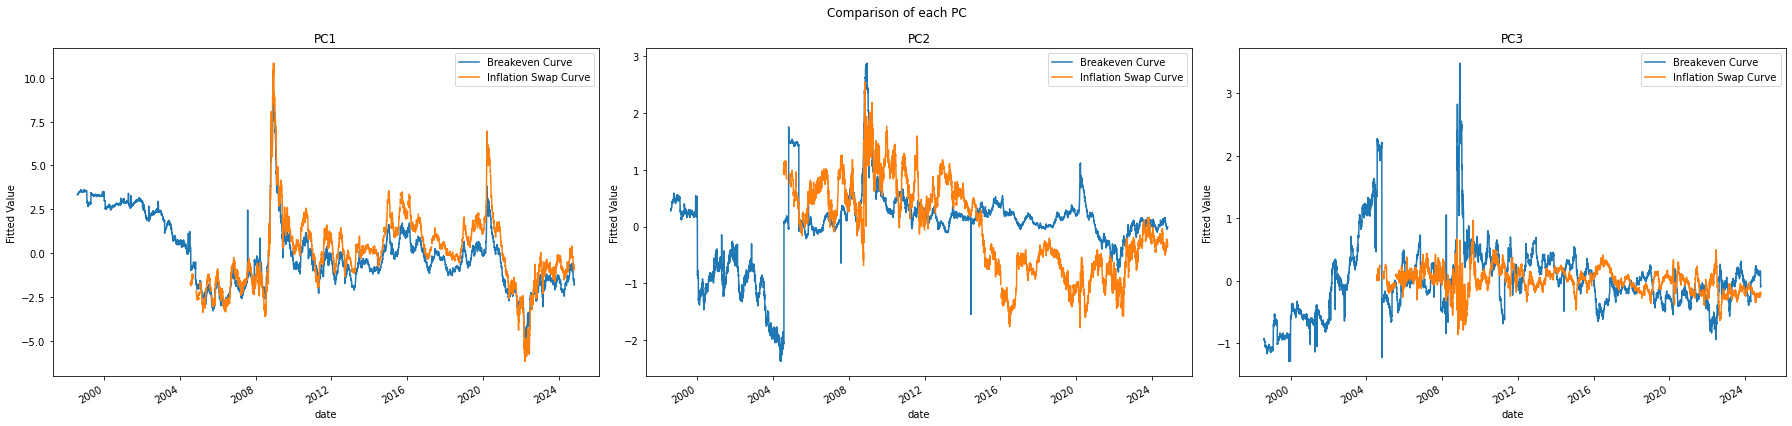

In [6]:
def plot_pc_comparison(df_fitted: pd.DataFrame) -> plt.Figure: 
    
    df_longer = (df_fitted.reset_index().melt(
        id_vars = ["date", "inflation_group"]))

    group_vars = df_longer.variable.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (25,6))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_longer.query(
            "variable == @group_var").
            drop(columns = ["variable"]).
            assign(inflation_group = lambda x: np.where(x.inflation_group == "BreakevenRate", "Breakeven Curve", "Inflation Swap Curve")).
            rename(columns = {"inflation_group": ""}).
            pivot(index = "date", columns = "", values = "value").
            plot(
                ax     = ax,
                ylabel = "Fitted Value",
                title  = group_var))

    fig.suptitle("Comparison of each PC")
    plt.tight_layout()
    
plot_pc_comparison(df_fitted)

In [7]:
def get_explained_variance() -> pd.DataFrame:
    
    data_path = r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\data\PCExpVar"

    df_exp_var = (pd.concat([
        (pd.read_parquet(
            path   = os.path.join(data_path, path), 
            engine = "pyarrow").
            assign(inflation_group = path.split(".")[0])) 
        for path in os.listdir(data_path)]).
        reset_index().
        pivot(index = "index", columns = "inflation_group", values = "exp_var").
        cumsum().
        reset_index().
        melt(id_vars = "index"))
    
    return df_exp_var

df_exp_var = get_explained_variance()

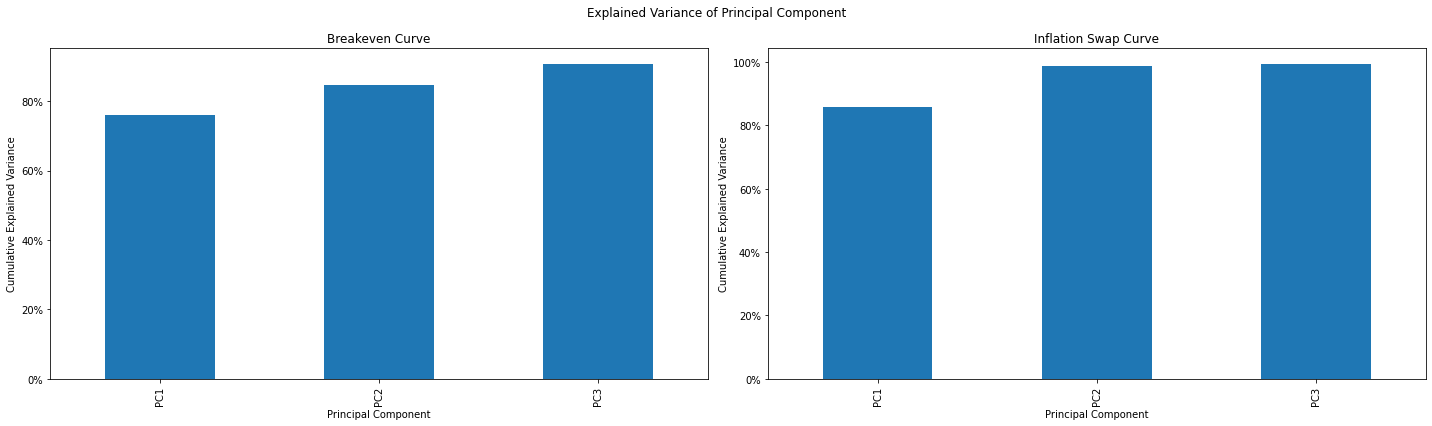

In [8]:
inflation_groups = df_exp_var.inflation_group.drop_duplicates().to_list()
fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (20,6))

renamer = {
    "BreakevenRate" : "Breakeven Curve",
    "InflationSwaps": "Inflation Swap Curve"}

for inflation_group, ax in zip(inflation_groups, axes.flatten()):
    
    (df_exp_var.query(
        "inflation_group == @inflation_group").
        drop(columns = ["inflation_group"]).
        set_index("index").
        plot(
            kind   = "bar",
            ax     = ax,
            legend = False,
            xlabel = "Principal Component",
            ylabel = "Cumulative Explained Variance",
            title  = renamer[inflation_group]))
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    
fig.suptitle("Explained Variance of Principal Component")
plt.tight_layout()

In [9]:
def get_loadings() -> pd.DataFrame: 
    
    data_path = r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\data\PCLoadings"

    df_loadings = (pd.concat([(pd.read_parquet(
        path   = os.path.join(data_path, path), 
        engine = "pyarrow").
        T.
        assign(inflation_group = path.split(".")[0])) 
        for path in os.listdir(data_path)]).
        reset_index().
        rename(columns = {"index": "ticker"}).
        assign(tenor = lambda x: x.ticker.str[-2:].str.replace("T", "").astype(int)))
    
    return df_loadings

df_loadings = get_loadings()

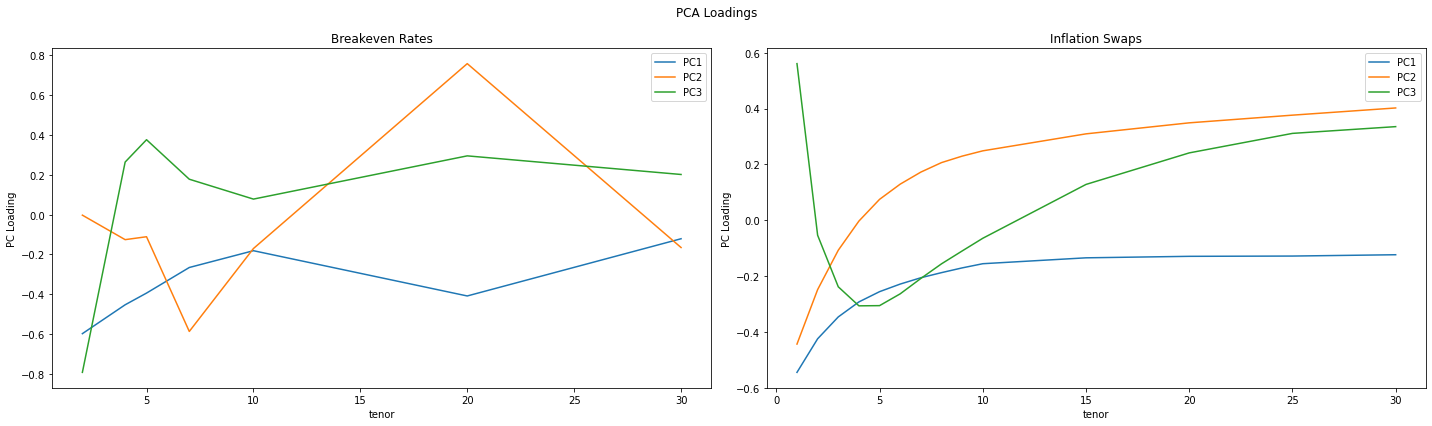

In [10]:
def plot_loadings(df_loadings: pd.DataFrame) -> plt.Figure: 
    
    inflation_groups = df_loadings.inflation_group.drop_duplicates().to_list()
    fig, axes        = plt.subplots(ncols = len(inflation_groups), figsize = (20,6))

    renamer = {
        "BreakevenRate" : "Breakeven Rates",
        "InflationSwaps": "Inflation Swaps"}

    for inflation_group, ax in zip(inflation_groups, axes.flatten()): 

        (df_loadings.query(
            "inflation_group == @inflation_group").
            set_index("tenor").
            sort_index().
            drop(columns = ["ticker", "inflation_group"]).
            plot(
                ax     =  ax,
                ylabel = "PC Loading",
                xlabel = "tenor",
                title  = renamer[inflation_group]))

    fig.suptitle("PCA Loadings")
    plt.tight_layout()
    
plot_loadings(df_loadings)

## OLS model

first begin by running a full regression of all commodities against each PC and then taking the t-stat of the beta

In [11]:
def _get_ols_tstat(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.PX_rtn,
        exog  = sm.add_constant(df.value)).
        fit())
    
    df_out = (pd.DataFrame(
        data    = model.pvalues,
        columns = ["t_stat"]).
        reset_index().
        rename(columns = {"index": "var"}).
        query("var == 'value'"))
    
    return df_out

def get_tstats(df_fitted: pd.DataFrame) -> pd.DataFrame: 

    data_path = r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\data\RawData\CommodFutures.parquet"

    df_fitted_prep = (df_fitted.reset_index().melt(
        id_vars = ["date", "inflation_group"]))

    df_stat = (pd.read_parquet(
        path = data_path, engine = "pyarrow").
        merge(right = df_fitted_prep, how = "inner", on = ["date"]).
        assign(group_var = lambda x: x.security + " " + x.inflation_group + " " + x.variable).
        groupby("group_var").
        apply(_get_ols_tstat).
        reset_index().
        drop(columns = ["level_1"]).
        assign(
            security        = lambda x: x.group_var.str.split(" ").str[0],
            inflation_group = lambda x: x.group_var.str.split(" ").str[1],
            variable        = lambda x: x.group_var.str.split(" ").str[2]).
        drop(columns = ["group_var"]))
    
    return df_stat

df_stat = get_tstats(df_fitted)

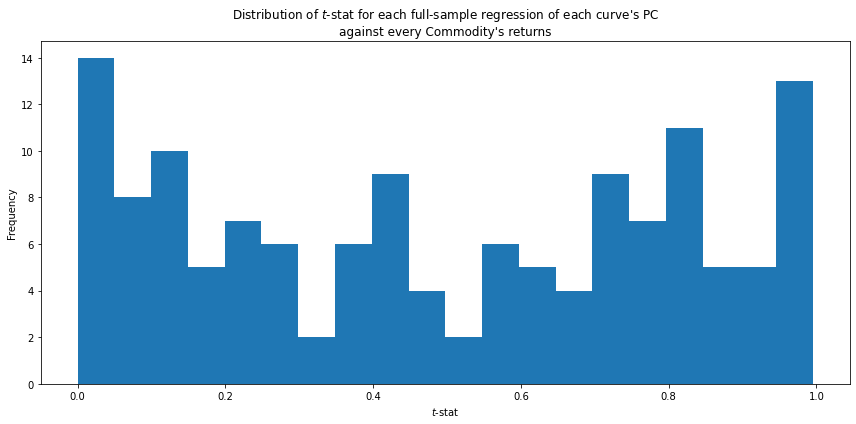

In [12]:
def plot_tstat_dist(df_stat: pd.DataFrame) -> plt.Figure:
    
    df_stat.t_stat.plot(
        figsize = (12,6),
        kind    = "hist", 
        bins    = 20,
        xlabel  = "$t$-stat",
        title   = "Distribution of $t$-stat for each full-sample regression of each curve's PC\nagainst every Commodity's returns")
    
    plt.tight_layout()
    
plot_tstat_dist(df_stat)

The implication of this can be a coule of things things (or a combination of all) <br>
1. The modelling of inflation expectation via PCA of the curves are not accurate estimators of inflation expectation 
2. The causal relationship is not a strong as mentioned
3. Inflation is a statistical driver of inflation but US-based inflation is not the main
4. The OLS model can't fully capture the relationship between the PCs and the commodity's return <br> <br>
All of which are likely in play and tough barriers to overcome. The use of breakeven rates as leading indicators for inflation is prevalent (see [*The Fred Blog: Measuring expected inflation with breakevens*](https://fredblog.stlouisfed.org/2021/12/measuring-expected-inflation-with-breakevens/)). And the inflation swap market is traded purely on an *expected-inflation-basis*. The second hypothesis is likely not true, as inflation tends to be a key driver for inflationary periods, although its appeal during those times has started to be questioned (see [*Robeco: Gold is back as an asset class*](https://www.robeco.com/en-us/insights/2024/10/gold-is-back-as-an-asset-class)). Global inflation tends to be the driver for this model the US economy should have enough spillover inflation (or vice versa inflation that spills over) to the global economy making it a proxy. It should be noted that say geopolitical spikes can occur. The OLS model should be able to capture the complexities of the relationship, but the factor uses $\beta$ of 30d rolling OLS which is negated by the low $t$-stat for the full sample.